In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import scipy.ndimage as nd
from numba import njit
rng = np.random.default_rng()

%matplotlib notebook
plt.style.use("classic")
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.facecolor'] = '#E4E4E0'
plt.rcParams["figure.facecolor"] = "#E4E4E0"
plt.rcParams["font.sans-serif"] = ["Helvetica"]
plt.rcParams["axes.xmargin"] = 0.05
plt.rcParams["axes.ymargin"] = 0.05
plt.rcParams["axes.autolimit_mode"] = "data"
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["image.cmap"] = "gnuplot"

warnings.filterwarnings(
    action='ignore',
    category=matplotlib.MatplotlibDeprecationWarning
)

def plot(x=None, y=None, *args, **kwargs):
    global fig, ax
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if x is not None and y is not None:
        ax.plot(x, y, *args, **kwargs)
    elif x is not None:
        ax.plot(x, *args, **kwargs)

def pcpl(z, x=None, y=None, *args, **kwargs):
    global fig, ax
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if x is not None and y is not None:
        mesh = ax.pcolormesh(x, y, z, *args, **kwargs)
    else:
        mesh = ax.pcolormesh(z, *args, **kwargs)
    fig.colorbar(mesh)

# Problem

**Input:** an $M\times N$ array $A$ of integers. Each entry of $A$ is either 0, -1, or -2, representing a *gate*, a *wall*, or an *empty space*.

**Output:** an $M\times N$ array $B$ of integers. When $A[i, j]$ is an empty space ($A[i, j] = -2$), $B[i, j]$ is the length of the shortest path from any entry of $A$ that is a gate to entry $(i, j)$, among all paths that do not cross walls. A path is any sequence of indices obtained by moving up, down, left, or right, one at a time (so paths do not move diagonally, only in four directions). 

In [35]:
gate = 0
wall = -1
empty = -2

## Method

Each cell of $B$ has a current value. It looks at its four neighbors' current values to see what its new value should be. All cells determine their new values at the same time, and then replace their current value with the new one. 

The `update()` function below shows how each cell updates its value. Walls and gates do not change their values. Other cells take the minimum $m$ among all nonnegative neighbor values, and compare $m+1$ to their own current value $c$. They replace their current value with $\min(m+1, c)$ if $c > 0$, or $m+1$ if $c = -2$.

The meaning of this procedure is that the length of the shortest path from any gate to myself must be one plus the length of any shortest path from that gate to a neighbor of mine.

In [68]:
@njit
def update(neighbors, myself):
    m = myself
    if m == wall or m == gate:
        return m
    for n in neighbors:
        if n >= 0 and (n+1 < m or m == empty):
            m = n+1
    return m

Repeat `update()` on $A$ until no cell changes its value:

In [89]:
@njit
def step(A):
    # requires walls on all edges of A
    done = True
    B = np.empty_like(A)
    B[0, :] = B[-1, :] = B[:, 0] = B[:, -1] = wall
    M, N = A.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            neighbors = [
                A[i-1, j],
                A[i+1, j],
                A[i, j-1],
                A[i, j+1]
            ]
            B[i, j] = update(neighbors, A[i, j])
            if A[i, j] != B[i, j]:
                done = False
    return B, done

## Test

Now, create a random maze:

In [126]:
N = 512
maze = np.zeros((N, N))
maze = nd.gaussian_filter(rng.uniform(-1, 1, (N, N)), N//32)
maze = (maze < 1/N) & (maze > -1/N)
maze[0, :] = maze[-1, :] = maze[:, 0] = maze[:, -1] = 1

A = empty + maze
c = 1/(10*N)
for i in range(N):
    for j in range(N):
        if A[i, j] == empty and rng.uniform(0, 1) < c:
            A[i, j] = gate

<IPython.core.display.Javascript object>


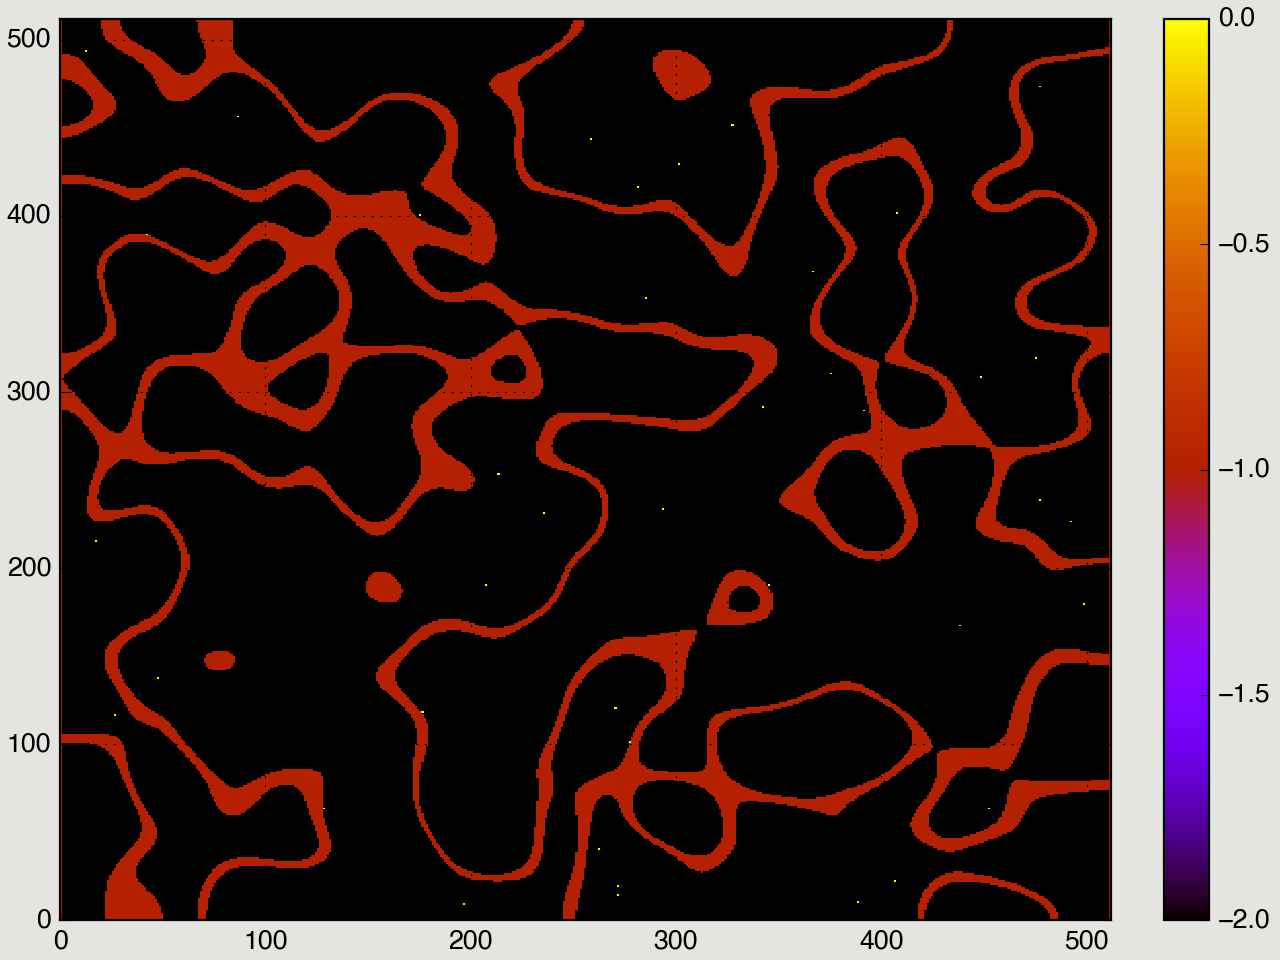

In [127]:
pcpl(A)

### A few iterations

In [128]:
B, done = step(A)
B, done = step(B)
B, done = step(B)
B, done = step(B)
B, done = step(B)
B, done = step(B)

<IPython.core.display.Javascript object>


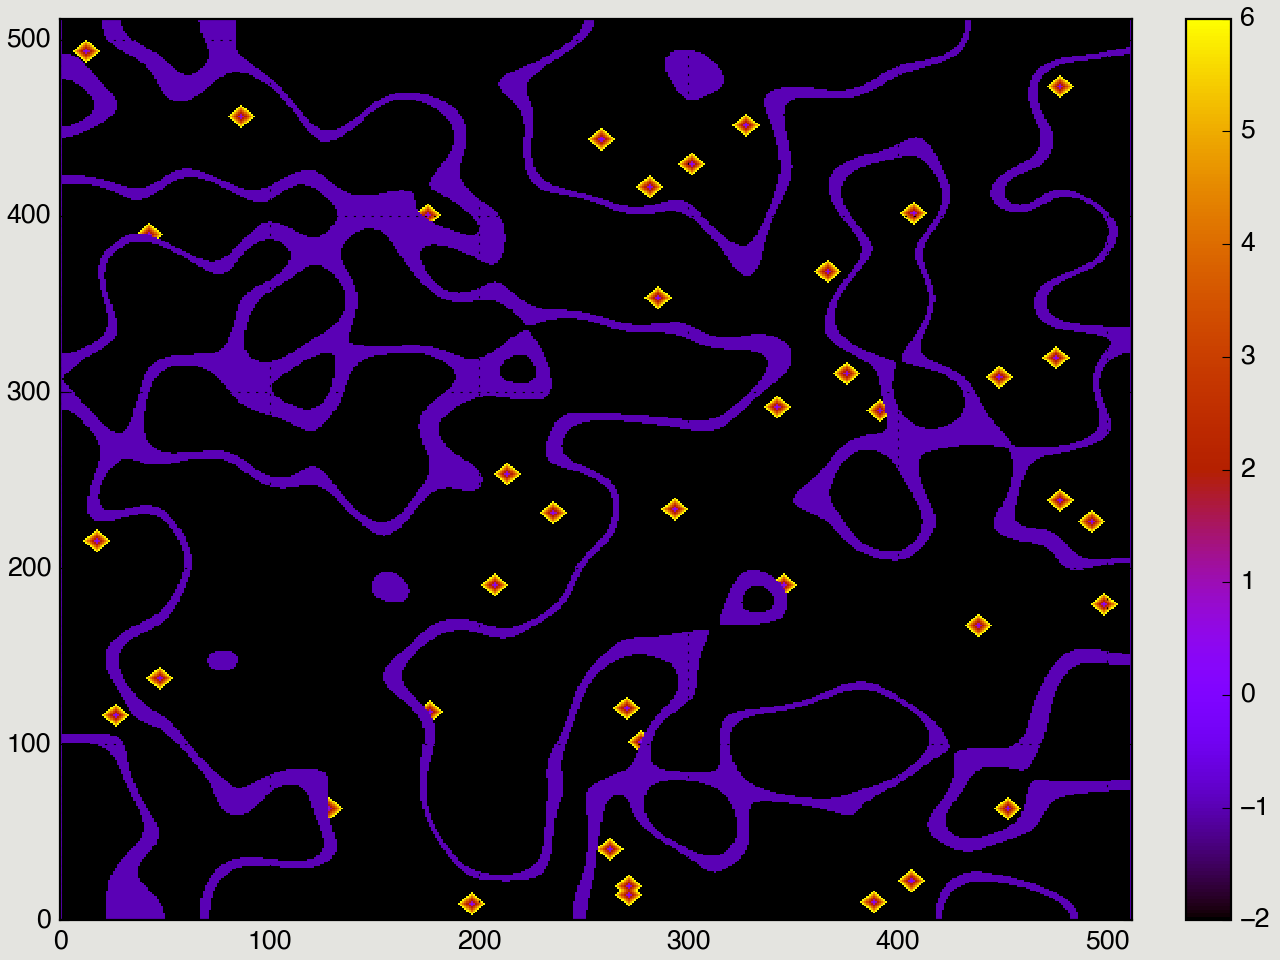

In [129]:
pcpl(B)

### Repeat until convergence

In [ ]:
done = False
B = np.array(A)
while not done:
    B, done = step(B)

In [ ]:
pcpl(B)